# Basic Text Classification with Naive Bayes

In this mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the Rotten Tomatoes database. You'll also use a fundamental technique in Bayesian inference, called [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

### Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Setup

In [1]:
import itertools

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp

#from six.moves import range

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB

# Set up Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set up Seaborn
sns.set_style("whitegrid")
sns.set_context("notebook")

# %matplotlib inline

## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('data/critics.csv')
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27631 entries, 0 to 27630
Data columns (total 8 columns):
critic         23740 non-null object
fresh          27631 non-null object
imdb           27631 non-null int64
publication    27631 non-null object
quote          15561 non-null object
review_date    27631 non-null object
rtid           27631 non-null int64
title          27631 non-null object
dtypes: int64(2), object(6)
memory usage: 1.7+ MB


In [3]:
# drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
# critics.sample(15)

### Explore

In [4]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_ratings = critics.fresh.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))
print("Number of ratings:  {:d}".format(n_ratings))
print("Ratings options:", critics.fresh.unique())

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921
Number of ratings:  3
Ratings options: ['fresh' 'rotten' 'none']


<blockquote>
    Certified Fresh status is a special distinction awarded to the best-reviewed movies and TV shows. In order to qualify, movies or TV shows must meet the following requirements:
   * A steady Tomatometer score of 75% or higher.
   * At least five reviews from Top Critics.
   * Films in wide release must have a minimum of 80 reviews.
   * Films in limited release must have a minimum of 40 reviews.
   * Only individual seasons of a TV show are eligible, and each must have a minimum of 20 reviews.
    <a href=https://www.rottentomatoes.com/about#whatisthetomatometer>ref</a>
</blockquote>

Also
<blockquote>
    Tomatometer. This score is based on the reviews from movie and television critics. It “measures the percentage [of audience scores] that are more positive than negative, and assigns an overall fresh or rotten rating to the movie. Scores of over 60 percent are considered fresh, and scores of 59 percent and under are rotten” - 
    <a hef=https://towardsdatascience.com/can-we-predict-rotten-tomatoes-ratings-8b5f5b7d7eff>ref</a>
</blockquote>

In [5]:
df = critics.copy()
df['fresh'] = (df.fresh == 'fresh')  # Set "Fresh" value to True or False
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic
means = means.round(2)

# df.head()

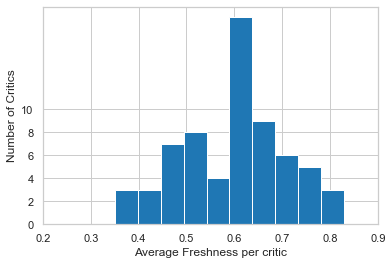

In [6]:
means[counts > 50].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Freshness per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);
plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]);

## Exercise Set I

<div class="span5 alert alert-info">

<b>Exercise:</b> Look at the histogram above. Tell a story about the average freshness per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

The shape looks bimodal, with a large peak between 0.6 and 0.7.

**What is interesting about the distribution?** Apparently, the frequent critics (more than 50 comments; I changed this value) spend more than half their time commenting on titles in the _Fresh_ list. No one comments only on movies in the _Fresh_ list, but less than half  of the critics spend more than 40% of their reviews on "not fresh" titles.

As I assume that the "not fresh" titles are also viewed less often, this is not pariculaly surprising.

Personally, I don't understand this part of the exercise. The _Fresh_ rating pertains to the movie, not to any specific rating an individual critic gave it. So, getting the mean of the _Fresh_ movies only shows that the average critic spends more than half of their time commenting on "fresh" movies.

How is this useful information?

<hr style="border: 3px solid green;">

# Background information on documents, text mining and natural language processing

## The Vector Space Model and a Search Engine

Quotes and diagrams below are excerpted from [*Introduction to Information Retrieval*]( http://nlp.stanford.edu/IR-book/), by Manning et. al., which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by
  $$\bar V(d)$$
  
What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then  associate an array index with them, e.g., "hello" might be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

A set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features (words) in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is, "cat ate rat" and "rat ate cat" have the same represenaion. This representation is also known as the Bag-Of-Words representation.

Below is another example from <i>Introduction to Information Retrieval</i>; this matrix has been transposed so that documents are columns:

![novel terms](data/terms.png)

Such a matrix is also called a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, after stemming, `jealous` and `jealousy` are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: `work`, `working`, and `worked` would all reduce to `work`. We could remove "stopwords", such as common words like "the", from our vocabulary. We could look for particular parts of speech, such as adjectives; this is often done in Sentiment Analysis. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](data/vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query $q$ = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](data/terms2.png)

>The key idea now: to assign to each document $d$ a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

## Explanatory Code

In [7]:
# from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier 
# in this assignment to convert back to a "normal" numpy array
xa = x.toarray()

print("")
print("Transformed text vector is {}".format(type(x)))
print("")
print("Transformed text vector (array) is \n{}".format(xa))

# `get_feature_names` tracks which word is associated with each column 
# of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the 
# *order* of words, just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is <class 'scipy.sparse.csr.csr_matrix'>

Transformed text vector (array) is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [8]:
def make_xy(words, vectorizer=None):
    """
     Vectorize, fit, and transform a vocabulary set
 
     Input: 
         words: a pandas series 
         vectorizer: uses CountVectorizer() if value is not supplied
       
     Output: 
       X: CSC format word matrix
       y: Boolean array of title "freshness" as 0 or 1       
    """
    
    # from sklearn.feature_extraction.text import CountVectorizer
    #  This implementation produces a sparse representation of the counts
    #  using scipy.sparse.csr_matrix. (Compressed Sparse Row matrix)
    
    if vectorizer is None:
        vectorizer = CountVectorizer()
        
    # build the vocabulary and transform to a "bag of words"
    X = vectorizer.fit_transform(words)
    
    # Convert matrix to Compressed Sparse Column (CSC) format
    X = X.tocsc()  
    
    # Array of Boolean values, 0 or 1
    y = (critics.fresh == 'fresh').values.astype(np.int)
    
    return X, y
#end_def


In [9]:
vectorizer = CountVectorizer(min_df=1)
X, y = make_xy(critics.quote, vectorizer)

# X, y

## From Bayes' Theorem, we have

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$


$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

### Other Likelihood Functions

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

## Exercise Set II

<div class="span5 alert alert-info">
<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

<blockquote>

<tt>class sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)</tt>

Naive Bayes classifier for multinomial models

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work. -- [ref: API doc](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

[User guide](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)
</blockquote>

In [10]:
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score

def nb_clf(X, y):
    """
     Implement a simple Naive Bayes classifier
     Identify accuracy via training set
     * X and y should already be vectorized using make_xy() *
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

    # instantiate the model
    model = MultinomialNB()

    # fit with the training set
    model.fit(X_train, y_train)

    # predict on the test set
    y_pred = model.predict(X_test)

    # compare accuracy between training and test 
    print("training accuracy:", model.score(X_train, y_train))

    # Thse two should be the same
    print("test accuracy:", model.score(X_test, y_test))
    print("prediction accuracy:",accuracy_score(y_test,y_pred)) 

nb_clf(X, y)

training accuracy: 0.9209083119108826
test accuracy: 0.7782061166795168
prediction accuracy: 0.7782061166795168


**What do you notice? Is this a good classifier? If not, why not?**

This is not a good classifier. It has 92% accuracy on the training set but only 78% on the test set.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. 

From the documentation:

>min_df: When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. This value is also called 'cut-off' in the literature. If float, the parameter represents a proportion of documents; an integer represents absolute counts. This parameter is ignored if vocabulary is not None.

## Exercise Set III

<div class="span5 alert alert-info">
<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [11]:
# X is the transformed word vector. It contains word frequency per review
# We want to know if a word is in a document; not how many times it occurs
Xa = X.toarray()
Xbool = np.array(Xa, dtype=bool)
docs_per_word = Xbool.sum(axis=0) 

docs_per_word, docs_per_word.max()

(array([ 7,  1, 10, ...,  3,  1,  1]), 9502)

In [12]:
doc_count = n_reviews
N_or_fewer = {}
for n in range(doc_count + 1):
    N_or_fewer[n] = np.sum(docs_per_word <= n)

res = dict(itertools.islice(N_or_fewer.items(), 10)) 

In [13]:
df = pd.DataFrame.from_dict(N_or_fewer, orient='index')

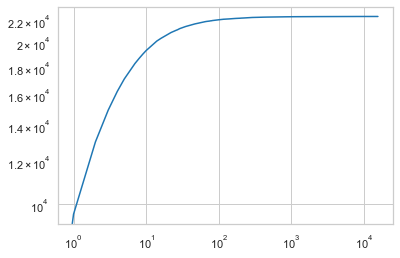

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(df, scalex=True, scaley=True )
plt.xscale('log')
plt.yscale('log')

If I've done this correctly, I would choose `min_df=1` and `max_df=90`.

<hr style="border: 1px solid green;">

## Choosing Alpha

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [15]:
# from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, nfold times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [16]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    fresh = y == 1
    rotten = ~fresh  # This isn't strictly true; there are also "none" values
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We will use the "log-likelihood" as the score in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [17]:
# from sklearn.model_selection import train_test_split

_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)

mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

## Exercise Set IV

<div class="span5 alert alert-info">
<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

**What does using the function `log_likelihood` as the score mean?** `log_likelihood` calculates probabiliies using `predict_log_proba` where the later funcion gives you the logarithm of the probabilities. "This is often handier as probabilities can become very, very small." The `log_likelihood` function  returns the sum of the logs of the probabilities of fresh and rotten reviews. We are trying to optimize for a higher log-likelihood result.

"In case you want to multiply those probabilities, they are often getting really small. If you add enough probabilities between > 0 and < 1, you will at some point run into floating point precision issues. Instead you can use the sum of logarithms." [ref](https://www.reddit.com/r/MLQuestions/comments/5lzv9o/sklearn_why_predict_log_proba/)

**Without writing any code, what do you think would happen if you choose a value of  𝛼  that is too high?** "The parameter  𝛼  is chosen to be a small value that simply avoids having zeros in the probability computations." and "Instead of using zeros, we add a small negligible value called  𝛼  to each count." A value that is too high would not be "negligible" and it would skew the results. We're simply trying to avoid zeros, not make major changes to the formula. [ref](https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf)

In [18]:
# from sklearn.naive_bayes import MultinomialNB

# mask is defined above

#the grid of possible alphas to try
alphas = [.1, 1, 5, 10, 50]
best_min_df = 1 # YOUR TURN: put your value of min_df here.

# Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore = -np.inf # start at negative infinity (is this low enough for you?)
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics.quote, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    
    clf = MultinomialNB(alpha = alpha)
    score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    
    try:
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
    except NameError:
        best_score = score
        
    print(alpha, score)


0.1 -922.6098837972946
1 -729.9753094831324
5 -1275.06325017669
10 -1430.2950629444008
50 -1383.1114250160117


In [19]:
print("alpha: {}".format(best_alpha))

alpha: 1


**Note** - "Using Laplace's rule of succession, some authors have argued that α should be 1 (in which case the term add-one smoothing is also used), though in practice a smaller value is typically chosen." [ref](https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf)

## Exercise Set V: 

<div class="span5 alert alert-info">
    <b>Working with the Best Parameters</b>
    
<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [20]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics.quote, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.935532
Accuracy on test data:     0.731822


 **Is this classifier better?** No. 
 
The previous classifier had
   * training accuracy: 0.9209083119108826
   * test accuracy: 0.7782061166795168
   
Here, the training accuracy went up a bit, but the test accuracy went down.

In [21]:
# from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1987 2269]
 [ 652 5984]]


What are we expected to understand from this confusion matrix?

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [22]:
# vectorizer is still our previously determined vector object
words = np.array(vectorizer.get_feature_names())

# Return an identity matrix 
# (a 2-D array with ones on the diagonal and zeros elsewhere)
x = np.eye(xtest.shape[1])

# Use the trained classifier to make predictions on this matrix
probs = clf.predict_log_proba(x)[:, 0]

# sort the rows by predicted probabilities
ind = np.argsort(probs)

# ind
# array([12154,  8651,  6505, ..., 11149, 11757, 20984]))

# pick the top and bottom 10 rows
good_words = words[ind[:10]]   # words[12154], words[8651], ...
bad_words = words[ind[-10:]]   # words[20984], words[11757], ...

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         beautifully 0.96
             delight 0.95
               grand 0.95
               truth 0.94
        accomplished 0.94
            superbly 0.93
              breath 0.93
            touching 0.93
         outstanding 0.93
              loving 0.93
Bad words	     P(fresh | word)
               shame 0.11
       disappointing 0.11
               tepid 0.11
             unfunny 0.11
          uninspired 0.10
             numbers 0.10
                dull 0.10
       unfortunately 0.09
           pointless 0.09
                lame 0.08


This is sad for John Leguizamo.

## Exercise Set VI

<div class="span5 alert alert-info">
<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

The identity matrix represents a data set where each row has exactly one feature (equivalent to a review containing exactly one word). We equate the probability of a "good" word to a "fresh" rating. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

<hr style="border: 1px solid green;">

### Prediction Errors

We can see mis-predictions as well.

In [23]:
x, y = make_xy(critics.quote, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?

The performances are precise, the language is alive and well spoken and the setting is striking, but Vanya on 42nd Street still suffers rather heavily from the limitations of filmed theater.

Simon Wells, whose other films include the animated The Prince of Egypt and Balto, manages to gut all the gee-whiz from the practically foolproof time-travel genre -- despite being H.G.'s real-life great-grandson.

I'll let you in on a little secret that film critics have known for years. A major studio production, released in August with top-list stars, is almost certain to be a gobbler.

What emerges in the end is a strange ambiguity of attitude to the American political system and a hollow humour about cultural values. 

## Exercise Set VII</h3>
<div class="span5 alert alert-info">
    <b>Predicting the Freshness for a New Review</b>
    <p>

<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>

</div>

In [24]:
# clf and vectorizer are still set from before
text = ['This movie is not remarkable, touching, or superb in any way'] 
x = vectorizer.transform(text) # return a matrix
x = x.toarray() 
predict = clf.predict(x)
if (predict == 1) :
    print('Fresh')
else:
    print('Not Fresh')

Fresh


**Is the result what you'd expect?** - Yes. Words like remarkable, touching, and superb are "good words". The minor "not" at the beginning doesn't have the same power as if the words were antonyms.

In [25]:
text = ['This movie is unremarkable, uninspired, and pointless in every way'] 
x = vectorizer.transform(text) # return a matrix
x = x.toarray() 
predict = clf.predict(x)
if (predict == 1) :
    print('Fresh')
else:
    print('Not Fresh')

Not Fresh


### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it.

We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** 

There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [26]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref

#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
X_tfidf=tfidf_vectorizer.fit_transform(critics.quote)